<a href="https://colab.research.google.com/github/symsssssss/KD_bug/blob/main/4_1%E2%80%94%E2%80%94KD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data


torch.manual_seed(0)   #设置随机数种子，使每次生成的随机数固定
torch.cuda.manual_seed(0)

In [48]:
class TeacherNet(nn.Module):    #教师网络
    def __init__(self):     #__init__函数
        super(TeacherNet, self).__init__() #super调用父类，在此super继承父类的__init__（）函数,第一个参数一般都命名为self
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  #二维卷积第一层：宽度和高度都进行卷积，输入通道数1，输出通道数32，卷积核尺寸3*3，池化大小为1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  #二维卷积第二层：宽度和高度都进行卷积，输入通道数32，输出通道数64，卷积核尺寸3*3
        self.dropout1 = nn.Dropout2d(0.3)     #Dropout2d第一层：防止过拟合，让30%的部分神经元随机置0不沿网络前向传播更新参数
        self.dropout2 = nn.Dropout2d(0.5)     #Dropout2d第二层：防止过拟合，让50%的部分神经元随机置0不沿网络前向传播更新参数
        self.fc1 = nn.Linear(9216, 512)    #全连接第一层： 输入神经元个数为9216，输出神经元个数为128，考虑偏置，卷积核尺寸1*1
        self.fc2 = nn.Linear(512, 10)     #全连接第二层： 输入神经元个数为128，输出神经元个数为10，考虑偏置，卷积核尺寸1*1


    def forward(self, x):   #前向传播函数
        x = self.conv1(x)
        x = F.relu(x)     #对卷积第一层采用激活函数relu
        x = self.conv2(x)
        x = F.relu(x)     #对卷积第二层采用激活函数
        x = F.max_pool2d(x, 2)  #对二维池化层采用最大池化操作，且步长为2即缩小2倍
        x = self.dropout1(x)    #训练的时候要用dropout，验证/测试的时候要关dropout。作用：将输入Tensor的元素按伯努利分布随机置0，防止过拟合
        x = torch.flatten(x, 1) #降维，1表示按行降维，0表示按列。按照x的第1个维度拼接（按照列来拼接，横向拼接）
        x = self.fc1(x)  
        x = F.relu(x)
        x = self.dropout2(x)
        output = self.fc2(x)         #前向函数直接把全连接层的输出未经过softmax直接输出
        return output


def train_teacher(model, device, train_loader, optimizer, epoch): #训练教师网络
    #训练固定语法
    model.train()  #训练部分固定语法，运行后，就告诉了BN层，对之后输入的每个batch独立计算其均值和方差，BN层的参数是在不断变化的。
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  #梯度初始化为零，把loss关于weight的导数变成0
        output = model(data)  # forward：将数据传入模型，前向传播求出预测的值
        loss = F.cross_entropy(output, target)     #求loss.因为未经过softmax所以要用交叉熵，也可在前向函数的全连接层使用log_softmax然后在此使用nll_loss，其实等价
        loss.backward()   # backward：反向传播求梯度
        optimizer.step()   # optimizer：更新所有参数
        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_teacher(model, device, test_loader):
    model.eval()  #测试部分固定语法，就是告诉BN层现在要用刚刚统计的μ和σ来测试我，不要再变μ和σ
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # 输出预测类别
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)


In [49]:
def teacher_main():
    epochs = 10      #所有样本训练10次
    batch_size = 64    #即每次训练在训练集中取64个样本训练
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #指定GPU训练

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,transform=transforms.Compose([
            transforms.ToTensor(),  #将PIL图像转换为范围[0255]中的张量（H*W*C）置（C*H*W）在[0.0,1.0]范围内
            transforms.Normalize((0.1307,), (0.3081,))  #用均值0.1307和标准差0.3081归一化张量图像
                       ])),
        batch_size=batch_size, shuffle=True)
    

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    
    model = TeacherNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())  #保持当前参数状态并基于计算得到的梯度进行参数更新
    
    teacher_history = []

    for epoch in range(1, epochs + 1):
        train_teacher(model, device, train_loader, optimizer, epoch)
        loss, acc = test_teacher(model, device, test_loader)
        
        teacher_history.append((loss, acc))

    torch.save(model.state_dict(), "teacher.pt")
    return model, teacher_history

In [50]:
# 训练教师网络

teacher_model, teacher_history = teacher_main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0447, accuracy: 9857/10000 (99%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0336, accuracy: 9886/10000 (99%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0318, accuracy: 9901/10000 (99%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0304, accuracy: 9908/10000 (99%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0299, accuracy: 9908/10000 (99%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0301, accuracy: 9919/10000 (99%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0273, accuracy: 9921/10000 (99%)
Train 

小插曲，看看老师的暗知识

In [51]:
import numpy as np
from matplotlib import pyplot as plt

def softmax_t(x, t):   #改进的softmax
    x_exp = np.exp(x / t)
    return x_exp / np.sum(x_exp)

test_loader_bs1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),    #将PIL图像转换为范围[0255]中的张量（H*W*C）置（C*H*W）在[0.0,1.0]范围内
        transforms.Normalize((0.1307,), (0.3081,))    #用均值0.1307和标准差0.3081归一化张量图像
    ])),
    batch_size=1, shuffle=True)

Output (NO softmax): [-28.341667  -35.360054  -33.788406  -35.781113  -36.776432  -21.957258
   1.1059268 -46.6071    -29.371717  -39.05533  ]


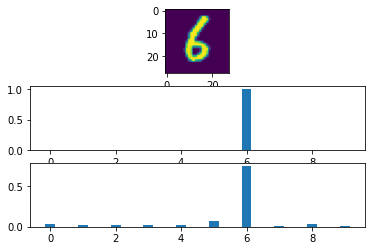

In [52]:
teacher_model.eval()
with torch.no_grad():
    data, target = next(iter(test_loader_bs1))
    data, target = data.to('cuda'), target.to('cuda')
    output = teacher_model(data)

test_x = data.cpu().numpy()
y_out = output.cpu().numpy()  
y_out = y_out[0, ::]   
print('Output (NO softmax):', y_out)  #y_out就是训练的概率



plt.subplot(3, 1, 1)
plt.imshow(test_x[0, 0, ::])

plt.subplot(3, 1, 2)
plt.bar(list(range(10)), softmax_t(y_out, 1), width=0.3)   #温度为1

plt.subplot(3, 1, 3)
plt.bar(list(range(10)), softmax_t(y_out, 10), width=0.3)   #温度为10
plt.show()

让老师教学生网络

In [53]:
class StudentNet(nn.Module):   #学生网络（教师模型传参）
    def __init__(self):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  #全连接第一层： 输入神经元个数为28*28，输出神经元个数为128，考虑偏置，卷积核尺寸1*1
        self.fc2 = nn.Linear(128, 64)     #全连接第二层： 输入神经元个数为128，输出神经元个数为64，考虑偏置，卷积核尺寸1*1
        self.fc3 = nn.Linear(64, 10)  #全连接第三层： 输入神经元个数为64，输出神经元个数为10，考虑偏置，卷积核尺寸1*1

    def forward(self, x): #前向传播函数
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))
        output = F.relu(self.fc3(x)) #激活函数relu对x非线性化3次
        return output

关键，定义kd的loss

In [54]:
def distillation(y, labels, teacher_scores, temp, alpha):  #定义损失函数
    return nn.KLDivLoss()(F.log_softmax(y / temp, dim=1), F.softmax(teacher_scores / temp, dim=1)) * (
            temp * temp * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)

In [55]:
def train_student_kd(model, device, train_loader, optimizer, epoch):   #训练学生网络

    #以下均为训练固定语句
    model.train()   #训练部分固定语法，运行后，就告诉了BN层，对之后输入的每个batch独立计算其均值和方差，BN层的参数是在不断变化的。
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        teacher_output = teacher_model(data)
        teacher_output = teacher_output.detach()  # 切断老师网络的反向传播，感谢B站“淡淡的落”的提醒
        loss = distillation(output, target, teacher_output, temp=5.0, alpha=0.7)
        loss.backward()
        optimizer.step()
        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_student_kd(model, device, test_loader):
    #以下均为测试固定语句
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [56]:
def student_kd_main():   #和教师网络训练只有teacher部分改成了student或student_loss
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)


    model = StudentNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    student_history = []

    for epoch in range(1, epochs + 1):
        train_student_kd(model, device, train_loader, optimizer, epoch)
        loss, acc = test_student_kd(model, device, test_loader)
        student_history.append((loss, acc))

    torch.save(model.state_dict(), "student_kd.pt")
    return model, student_history

In [57]:
student_kd_model, student_kd_history = student_kd_main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.2260, accuracy: 9633/10000 (96%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1420, accuracy: 9742/10000 (97%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1058, accuracy: 9801/10000 (98%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0998, accuracy: 9823/10000 (98%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0872, accuracy: 9820/10000 (98%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0823, accuracy: 9833/10000 (98%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0788, accuracy: 9853/10000 (99%)
Train 

In [58]:
## 让学生自己学，不使用KD
def train_student(model, device, train_loader, optimizer, epoch):
    #训练固定部分
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_student(model, device, test_loader):
    #测试固定部分
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [61]:
def student_main():   #和教师网络只有名字不一样而已
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)


    model = StudentNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    student_history = []
    
    for epoch in range(1, epochs + 1):
        train_student(model, device, train_loader, optimizer, epoch)
        loss, acc = test_student(model, device, test_loader)
        student_history.append((loss, acc))


    torch.save(model.state_dict(), "student.pt")
    return model, student_history

In [62]:
student_simple_model, student_simple_history = student_main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1256, accuracy: 9613/10000 (96%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1028, accuracy: 9714/10000 (97%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0947, accuracy: 9742/10000 (97%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0932, accuracy: 9774/10000 (98%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0976, accuracy: 9750/10000 (98%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0963, accuracy: 9773/10000 (98%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1004, accuracy: 9782/10000 (98%)
Train 

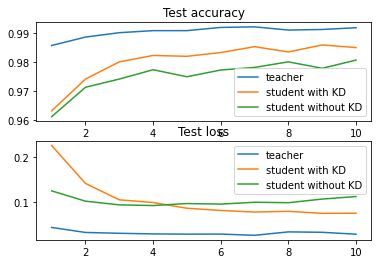

In [65]:
import matplotlib.pyplot as plt
epochs = 10
x = list(range(1, epochs+1))

plt.subplot(2, 1, 1)
plt.plot(x, [teacher_history[i][1] for i in range(epochs)], label='teacher')
plt.plot(x, [student_kd_history[i][1] for i in range(epochs)], label='student with KD')
plt.plot(x, [student_simple_history[i][1] for i in range(epochs)], label='student without KD')

plt.title('Test accuracy')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(x, [teacher_history[i][0] for i in range(epochs)], label='teacher')
plt.plot(x, [student_kd_history[i][0] for i in range(epochs)], label='student with KD')
plt.plot(x, [student_simple_history[i][0] for i in range(epochs)], label='student without KD')

plt.title('Test loss')
plt.legend()